# Darts: Deep Forecasting

## 1. Darts API

In [151]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import AutoARIMA, ExponentialSmoothing, StatsForecastETS
from darts.models import LightGBMModel, CatBoostModel, XGBModel
from darts.utils.utils import ModelMode
from darts.metrics import mape, mase, r2_score, mae

import seaborn as sns
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

### 1.1. Time series container
[`TimeSeries`] is the main data class in Darts. There can be various instaniation ways, but it is recommended to do this *indirectly* from a Pandas dataframe with [`DatetimeIndex`] for easy data cleaning.

[`TimeSeries`]: https://unit8co.github.io/darts/generated_api/darts.timeseries.html
[`DatetimeIndex`]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html

In [60]:
dfEco = (
    pd.read_csv('../data/macroeconomic.csv')
    .astype({'period': 'datetime64'})
    .set_index('period')
    .asfreq('QS')
)
tsEco = TimeSeries.from_dataframe(dfEco)

In [61]:
tsEco.pd_dataframe()

component,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
period,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-10-01,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-01-01,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


#### Basic methods

In [39]:
tsEco.dtype

dtype('float64')

In [40]:
tsEco.freq

<QuarterBegin: startingMonth=1>

In [41]:
tsEco.columns

Index(['realgdp', 'realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1',
       'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object', name='component')

In [60]:
tsEco.n_components

12

In [64]:
tsEco.n_timesteps

203

In [65]:
tsEco.duration

Timedelta('18444 days 00:00:00')

#### Slicing
Luckily, the slicing syntaxes is almost similar to Pandas dataframes. Except when you want to access specific times, we must use an appropriate Pandas object: a [`Timestamp`] for a single time, or a [`DatetimeIndex`] for multiple times. The later case can also be done indirectly with the help of the [`date_range()`] function.

[`Timestamp`]: https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html
[`DatetimeIndex`]: https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html
[`date_range()`]: https://pandas.pydata.org/docs/reference/api/pandas.date_range.html

In [40]:
# select a series
tsEco['realgdp']

# select multiple series
tsEco[['realgdp', 'realcons']]

pass

In [41]:
# select last 10 observations
tsEco[-10:]

# split the time series by ratio
tsEco.split_after(0.8)

# access a specific time stamp
tsEco[pd.Timestamp('2002-07-01')]

# access multiple time stamps
tsEco[pd.date_range(start='1959-01-01', end='1960-01-01', freq='QS')]

pass

#### Plotting

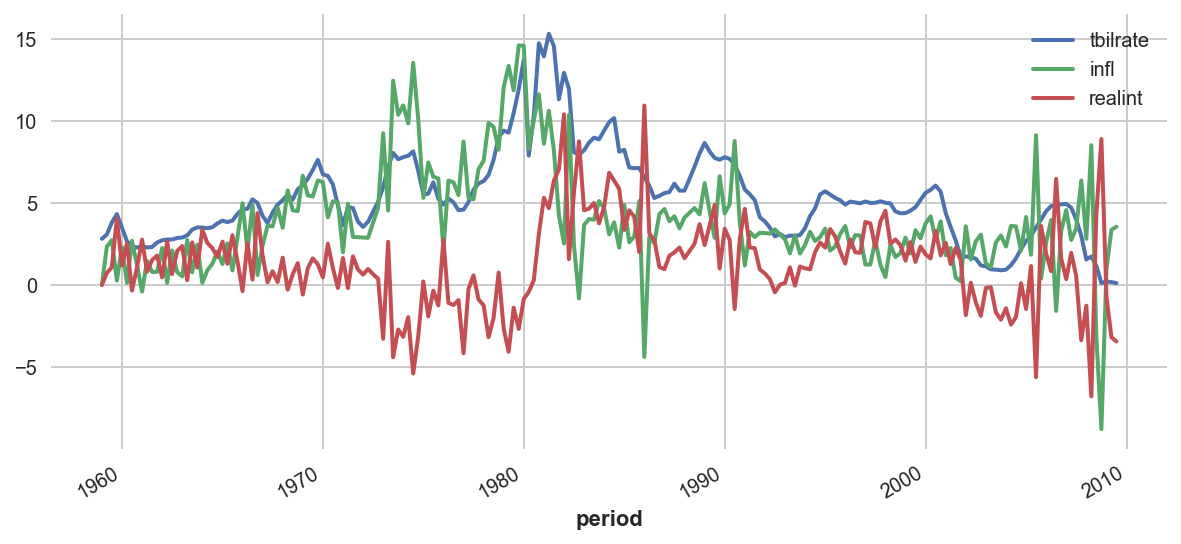

In [62]:
fig, ax = plt.subplots(figsize=(10,4))
tsEco[['tbilrate', 'infl']].plot()
tsEco['realint'].plot()

### 1.2. Data enrichment
With a univariate time series, there can be a lot of ways to create additional data. This section guides us through some techniques, made easy with Darts:
- basic time series transformations such as `diff()`, `lag()` and `shift()`
- `map()` the series to a new one using any Numpy function, then `stack()` it to the original
- `add_datetime_attribute()` to extract *cyclic attributes* from [`DatetimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html)
- `add_holidays()` to get a binary component representing holidays for a specific country, which reduces the need of [`CustomBusinessDay`](https://pandas.pydata.org/docs/reference/api/pandas.tseries.offsets.CustomBusinessDay.html)

In [90]:
dfQty = (
    pd.read_csv('../data/weekly_quantity.csv')
    .eval("date = date.astype('datetime64')", engine='python')
    .set_index('date')
)
tsQty = TimeSeries.from_dataframe(dfQty)

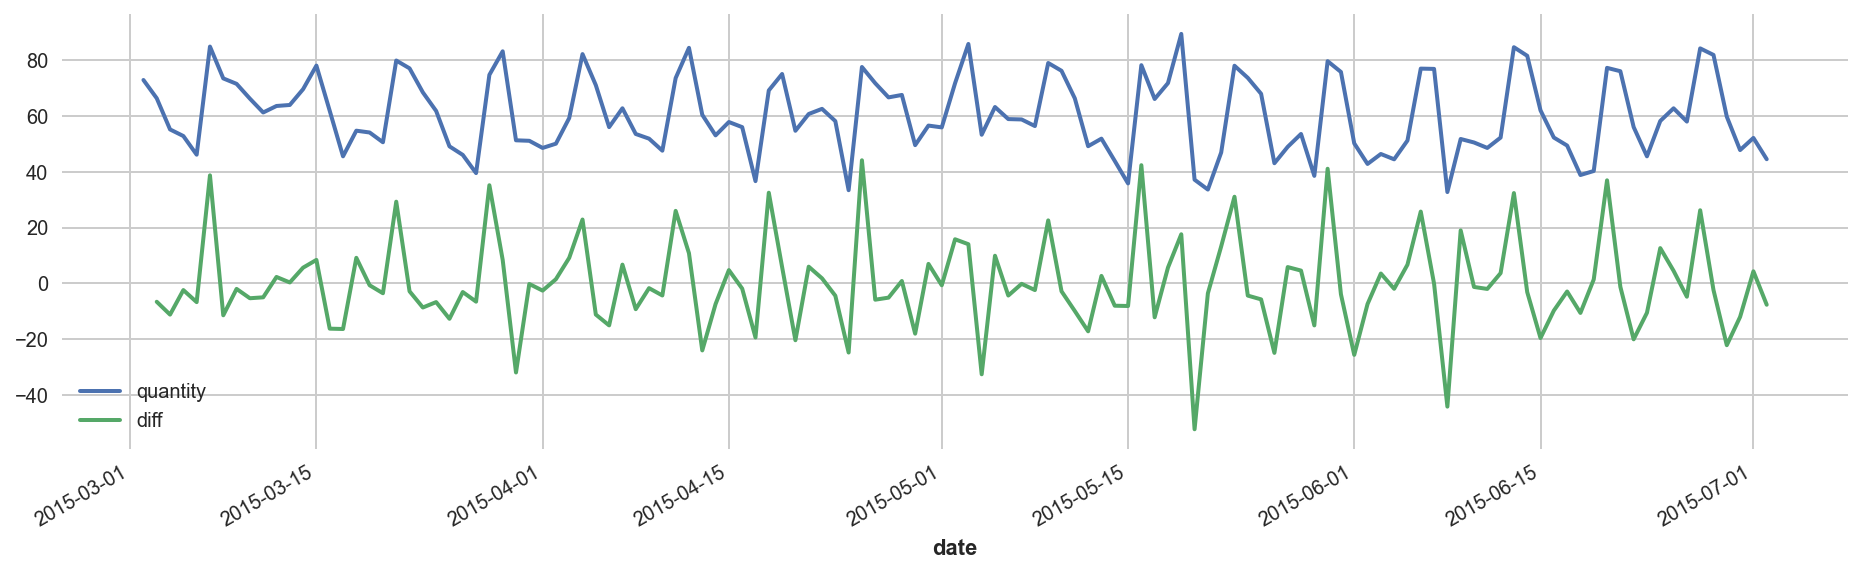

In [80]:
plt.figure(figsize=(16,4))
tsQty.plot()
tsQty.diff(1).plot(label='diff')

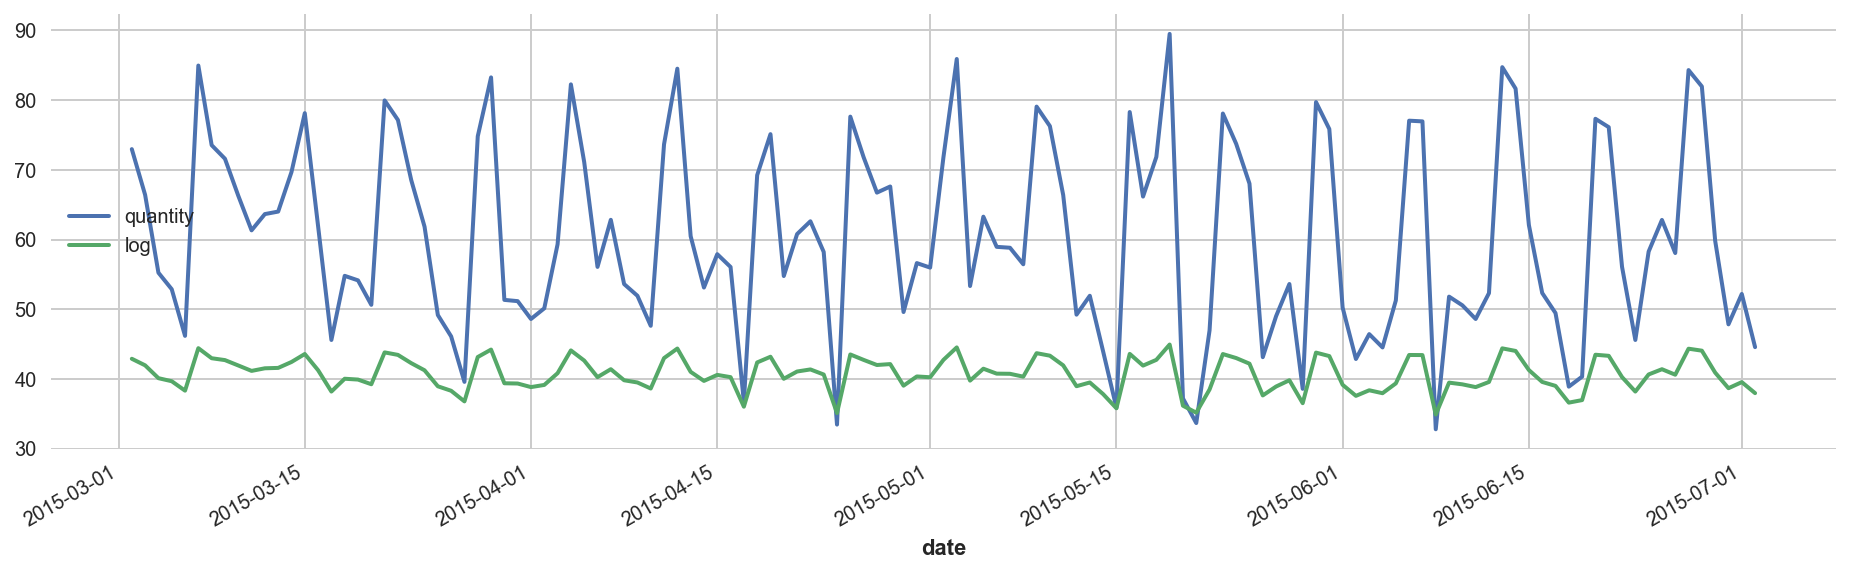

In [104]:
tsLog = tsQty.with_columns_renamed('quantity', 'log').map(np.log)*10

plt.figure(figsize=(16,4))
tsQty.stack(tsLog).plot()

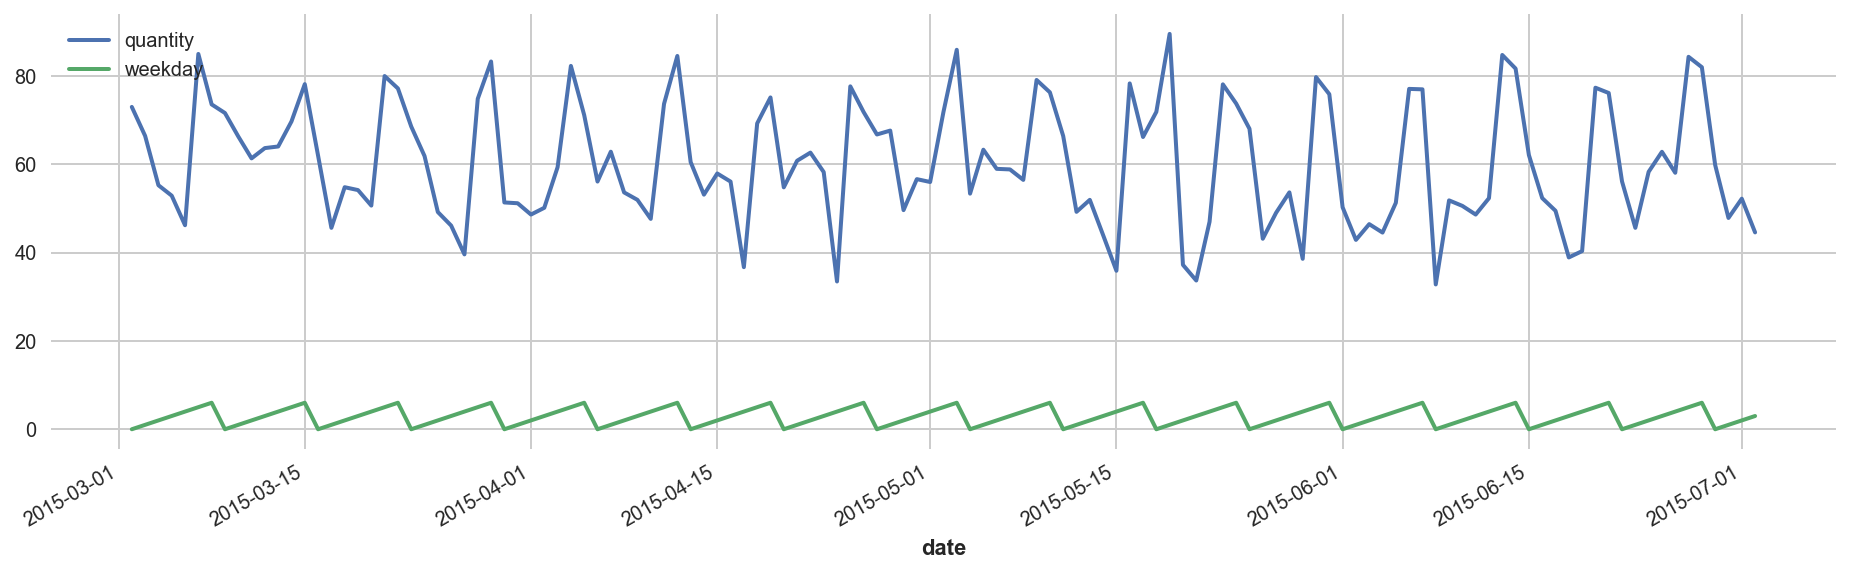

In [94]:
plt.figure(figsize=(16,4))
tsQty.add_datetime_attribute('weekday').plot()

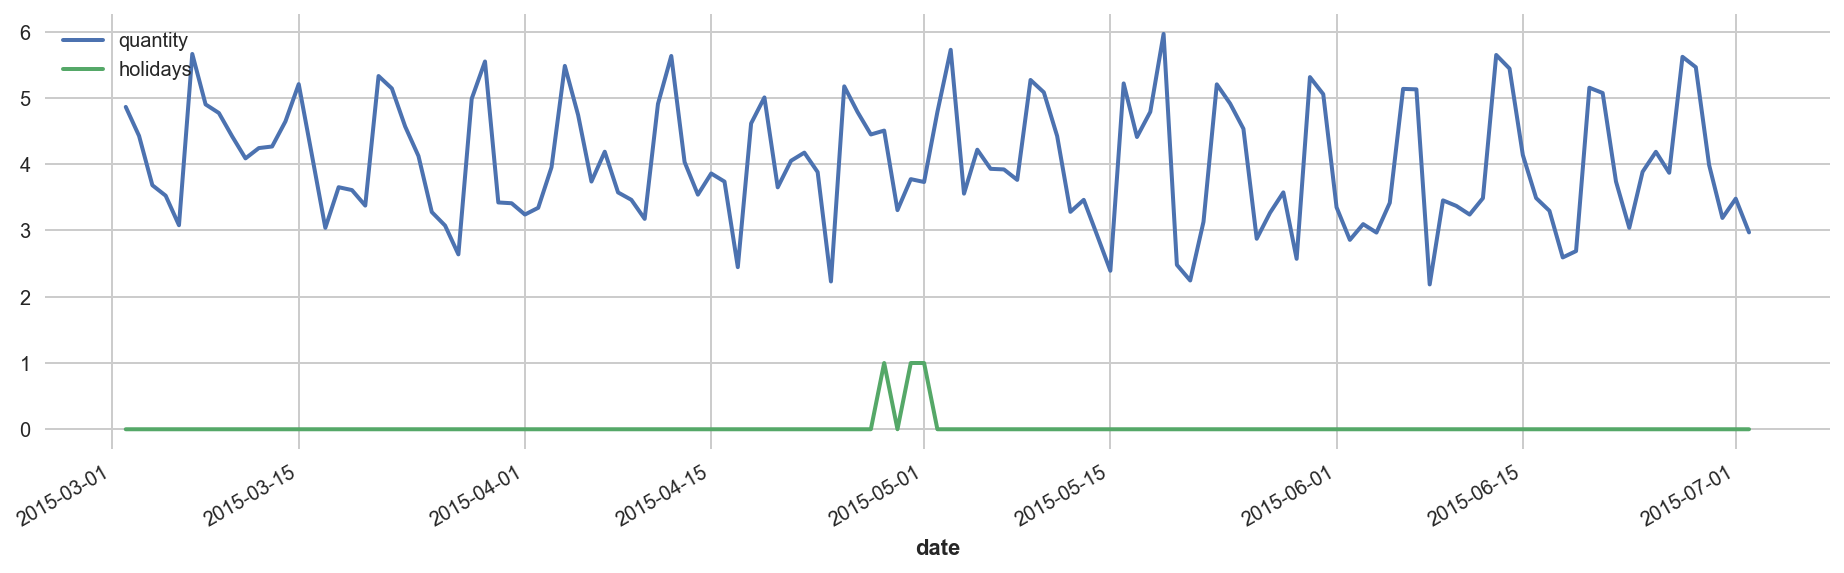

In [98]:
plt.figure(figsize=(16,4))
(tsQty/15).add_holidays('VN').plot()

### 1.3. Forecasting
Darts unifies a wide range of common forecasting algorithms:
- Statistical models: traditional [`AutoARIMA`], [`ExponentialSmoothing`], [`TBATS`] and modern [`Prophet`]
- Reduction to regression: general [`RegressionModel`] and state-of-the-art [`XGBModel`], [`LightGBMModel`], [`CatBoostModel`]
- Neural Networks: Darts implements various RNN-based architectures, which is the key difference with Sktime

[`AutoARIMA`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.auto_arima.html
[`ExponentialSmoothing`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.exponential_smoothing.html
[`TBATS`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tbats.html#darts.models.forecasting.tbats.TBATS
[`Prophet`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.prophet_model.html
[`RegressionModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html
[`XGBModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.xgboost.html
[`LightGBMModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.lgbm.html
[`CatBoostModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.catboost_model.html

In [112]:
dfEco = (
    pd.read_csv('../data/macroeconomic.csv')
    .astype({'period': 'datetime64'})
    .set_index('period')
    .asfreq('QS')
)
tsEco = TimeSeries.from_dataframe(dfEco)

In [115]:
dfEco.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
period,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [142]:
tsTrain = tsEco['realgovt'][:-20]
tsTest = tsEco['realgovt'][-20:]

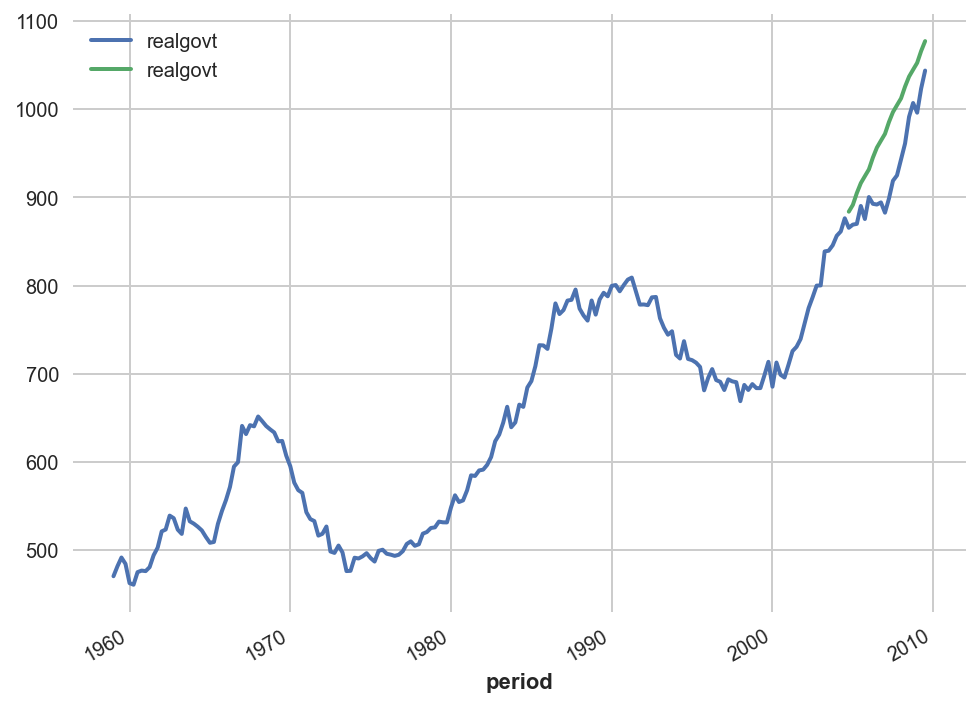

In [170]:
model = ExponentialSmoothing()
model.fit(tsTrain)
tsPred = model.predict(20)

tsEco['realgovt'].plot()
tsPred.plot()

### 1.4. Covariates

### 1.5. Backtesting

## 2. Deep forecasters

### 2.1. DeepAR
- API: [`BlockRNNModel`]
- Year: 2017
- Paper: https://arxiv.org/abs/1704.04110

[`BlockRNNModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.block_rnn_model.html

### 2.2. Transformer
- API: [`TransformerModel`]
- Year: 2017
- Paper: https://arxiv.org/abs/1706.03762

[`TransformerModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.transformer_model.html

### 2.3. N-BEATS
- API: [`NBEATSModel`]
- Year: 2019
- Paper: https://arxiv.org/abs/1905.10437

>

- API: [`NHiTSModel`]
- Year: 2022
- Paper: https://arxiv.org/abs/2201.12886


[`NBEATSModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
[`NHiTSModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nhits.html

### 2.4. TCN
- API: [`TCNModel`]
- Year: 2019
- Paper: https://arxiv.org/abs/1906.04397

[`TCNModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html

### 2.5. TFT
- API: [`TFTModel`]
- Year: 2019
- Paper: https://arxiv.org/abs/1912.09363

[`TFTModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html#id1

### 2.6. LTSF-Linear
- API: [`DLinearModel`], [`NLinearModel`]
- Year: 2022
- Paper: https://arxiv.org/abs/2205.13504

[`DLinearModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.dlinear.html
[`NLinearModel`]: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nlinear.html